# 5 Modeling

## Table of Contents:

* [5.1 Introduction](#5.1)
* [5.2 Import Packages](#5.2)
* [5.3 Load the Data](#5.3)
    * [5.3.1 Data Preprocessing Pipeline](#5.3.1)
* [5.4 Logistic Regression](#5.4)
    * [5.4.1 Logistic Regression Pipeline](#5.4.1)
    * [5.4.2 Logistic Regression Hyperparameter Tuning](#5.4.2)
* [5.5 Random Forest Classifier](#5.5)
    * [5.5.1 Random Forest Pipeline](#5.5.1)
    * [5.5.2 Random Forest Hyperparameter Tuning](#5.5.2)
* [5.6 XG Boost](#5.6)
    * [5.6.1 XG Boost Pipeline](#5.6.1)
    * [5.6.2 XG Boost Hyperparameter Tuning](#5.6.2)
* [5.7 Evaluating Model Performance](#5.7)
    * [5.7.1 Table of Results](#5.7.1)
* [5.8 Summary and Next Steps](#5.8)

## 5.1 Introduction<a id='5.1'></a>

In the previous notebook, "Step 4 - Preprocessing and Training Data Development", we saw from our Logistic Regression baseline model that using SMOTE to upsample the minority class training data greatly improved model performance. Without SMOTE, none of the instances was sorted as a true positive. 

In this notebook, we will focus on the "Modeling" step of the Data Science Method. We will develop pipelines that scales the data, reduces the dimensions with PCA, labels with KMeans, upsamples with SMOTE, and models the data with either Logistic Regression (as a baseline), Random Forest, or XG Boost. 

For each pipeline, we will conduct hyperparameter tuning using Randomized Search with 10-fold cross-validation.

This will allow us to compare the effects of each preprocessing step on the model performance.

## 5.2 Import Packages<a id='5.2'></a>

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import timeit
import time
import random
%matplotlib inline

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, RandomizedSearchCV, learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics import auc, precision_recall_curve, plot_precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, auc
# from sklearn.pipeline import Pipeline

from imblearn.pipeline import Pipeline #Use imblearn pipeline, sklearn pipeline is incompatible with samplers
from imblearn.over_sampling import SMOTE
import xgboost as xgb


## 5.3 Load the Data<a id='5.3'></a>

In [2]:
#Note, the index column gets loaded as its own column, 'Unnamed: 0'
#We should remove it as to not have it included with our features.

X_train = pd.read_csv('X_train.csv').drop(columns=['Unnamed: 0'])
X_test = pd.read_csv('X_test.csv').drop(columns=['Unnamed: 0'])
y_train = pd.read_csv('y_train.csv').drop(columns=['Unnamed: 0'])
y_test =pd.read_csv('y_test.csv').drop(columns=['Unnamed: 0'])

X_train_smote = pd.read_csv('X_train_smote.csv').drop(columns=['Unnamed: 0'])
y_train_smote = pd.read_csv('y_train_smote.csv').drop(columns=['Unnamed: 0'])
X_test_kmeans = pd.read_csv('X_test_kmeans.csv').drop(columns=['Unnamed: 0'])

### 5.3.1 Data Preprocessing Pipeline<a id='5.3.1'></a>

Pipelines are useful for streamlining processes. We can use pipelines to sequentially apply a list of transforms on our data. While we did process our data in the previous notebook and export the results as CSV files (X_train_smote, y_train_smote, and X_test_kmeans), we can recreate that process using a pipeline.

In this section, we will create a preprocessing pipeline, that will help us prepare the data suitable for modeling.

In [3]:
#define the steps in the pipeline

#np.log1p, use FunctionTransformer() so that we can put it into the pipeline
def log1p(X_input):
    return np.log1p(X_input)
log1p = FunctionTransformer(log1p)

#scaler
scaler = StandardScaler()

#pca, 50 components
pca = PCA(n_components=50, random_state=42)

#kmeans labels
#since change the input data, we need to define our own function, and use FunctionTransformer()
#we include kmeans in this step, since our input should be from the PCA step
def one_hot_kmeans_labels(X_input, n_clusters=7):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(X_input)
    labels = pd.DataFrame(kmeans.labels_, columns=['labels'])
    one_hot = pd.get_dummies(labels, columns=['labels'])
    
    for i in range(kmeans.n_clusters): #address when not a single point is assigned to one of the clusters
        if ('labels_'+str(i)) not in one_hot.columns:
            one_hot['labels_'+str(i)] = 0
    
    sorted_columns = one_hot.columns.sort_values() #alphebetize the columns so they're always in the correct order
    one_hot = one_hot.reindex(sorted_columns, axis=1)

    df = pd.concat([pd.DataFrame(X_input), one_hot], axis=1) #append the cluster labels as additional features
    
    return df
one_hot = FunctionTransformer(one_hot_kmeans_labels)

#smote
smote = SMOTE(random_state=42, k_neighbors=10, n_jobs=-1)

In [4]:
#compile the steps of the pipeline. 

train_steps = [('log', log1p), 
         ('scaler', scaler), 
         ('pca', pca), 
         ('one_hot', one_hot), 
         ('smote', smote)
        ]

train_preprocessor = Pipeline(steps=train_steps)

#Since we won't be doing SMOTE on X_test, we can create a separate pipeline with SMOTE removed.
#Care should be taken to fit the pipeline on X_train, then transforming on X_test.
test_steps = [('log', log1p), 
         ('scaler', scaler), 
         ('pca', pca), 
         ('one_hot', one_hot)
        ]
test_preprocessor = Pipeline(steps=test_steps)

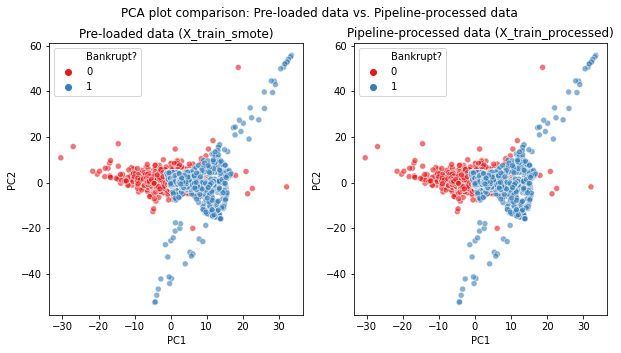

In [5]:
#Let's check whether this worked. Run the train_pipeline on X_train, and compare the results to X_train_smote.
X_train_processed, y_train_processed = train_preprocessor.fit_resample(X_train, y_train) #use fit_resample b/c SMOTE


#now plot them side-by-side, using PC1 and PC2. Use bankruptcy labels as hue.
#Note: we don't expect things like k-means cluster labels to be exactly the same, since results differ greatly 
# depending on where the cluster centers are initialized. 
# But at least the major PCs in PCA and the SMOTE should be similar.

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,5))
fig.suptitle('PCA plot comparison: Pre-loaded data vs. Pipeline-processed data')


sns.scatterplot(X_train_smote.iloc[:,0],X_train_smote.iloc[:,1],
                hue=y_train_smote.iloc[:,0], palette='Set1', 
                alpha=0.6, ax=ax1).set_title('Pre-loaded data (X_train_smote)')
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
ax1.legend()

sns.scatterplot(X_train_processed.iloc[:,0],X_train_processed.iloc[:,1],
                hue=y_train_processed.iloc[:,0], palette='Set1', 
                alpha=0.6, ax=ax2).set_title('Pipeline-processed data (X_train_processed)')
ax2.set_xlabel('PC1')
ax2.set_ylabel('PC2')
ax2.legend()
plt.show()

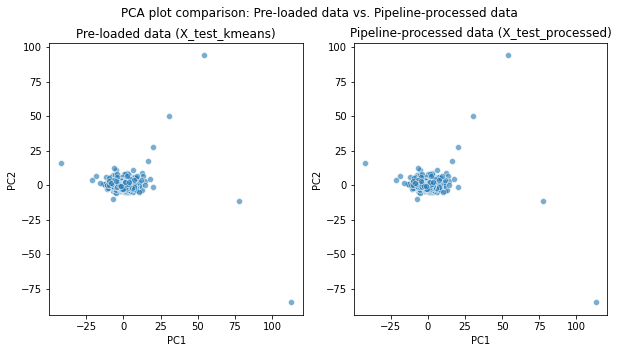

In [6]:
#Now let's check this on the test set. Run just the pipeline X_test, and compare the results to X_test_kmeans.

#fit on X_train
test_preprocessor.fit(X_train)
#transform X_test
X_test_processed = test_preprocessor.transform(X_test)

#now plot them side-by-side, using PC1 and PC2. Use bankruptcy labels as hue.
#Note: we don't expect things like k-means cluster labels to be exactly the same, since results differ greatly 
# depending on where the cluster centers are initialized. 
# But at least the major PCs in PCA and the SMOTE should be similar.

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,5))
fig.suptitle('PCA plot comparison: Pre-loaded data vs. Pipeline-processed data')


sns.scatterplot(X_test_kmeans.iloc[:,0],X_test_kmeans.iloc[:,1],
#                 hue=y_train_smote.iloc[:,0], palette='Set1', 
                alpha=0.6, ax=ax1).set_title('Pre-loaded data (X_test_kmeans)')
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
# ax1.legend()

sns.scatterplot(X_test_processed.iloc[:,0],X_test_processed.iloc[:,1],
#                 hue=y_processed.iloc[:,0], palette='Set1', 
                alpha=0.6, ax=ax2).set_title('Pipeline-processed data (X_test_processed)')
ax2.set_xlabel('PC1')
ax2.set_ylabel('PC2')
# ax2.legend()
plt.show()

The processed train data and processed test data all look great! We were able to verify that our pipeline-transformed data (X_train_processed, y_train_processed, and X_test_processed) worked correctly. 

The benefit of creating this pipeline allows us to include it in a larger pipeline and include it in hyperparameter tuning as we see fit.

## 5.4 Logistic Regression<a id='5.4'></a>

Logistic Regression is one of the simplest methods for binary classification. In statistics, the logistic model is used to model the probability of a certain class or event. In this case, we are modeling the probability that a company would go bankrupt, given a set of features. In our previous notebook, we used logistic regression as a baseline model. We do the same thing here, constructing a pipeline and tuning hyperparameters, then predicting the test set and later delving into alternative models like Random Forest and XG Boost.

For evaluation metrics, we look to the confusion matrix, accuracy, F1-score, precision, and recall to evaluate the performance of the model.

### 5.4.1 Logistic Regression Pipeline<a id='5.4.1'></a>


In [7]:
#define the model
#Note: we want to make sure the loss function used is cross entropy, so we must define multi_class='multinomial'.
lr = LogisticRegression(random_state=42, 
                        penalty = 'elasticnet', 
                        solver='saga', #saga solver must be used when penalty = 'elasticnet'
                        multi_class='multinomial', 
                        n_jobs=-1)

#make the pipeline
steps = [('log', log1p), 
         ('scaler', scaler), 
         ('pca', pca), 
         ('one_hot', one_hot), 
         ('smote', smote),
         ('lr', lr)
        ]

#definined steps as steps = [('preprocessor', train_preprocessor), ('lr', lr)] results in a type error.
#to avoid that, we needed to redefine the individual steps from train_preprocessor.

lr_pipeline = Pipeline(steps=steps)

### 5.4.2 Logistic Regression Hyperparameter Tuning<a id='5.4.2'></a>


In [8]:
#In order to set parameters to search over, we need to check the parameter names. 
lr_pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'log', 'scaler', 'pca', 'one_hot', 'smote', 'lr', 'log__accept_sparse', 'log__check_inverse', 'log__func', 'log__inv_kw_args', 'log__inverse_func', 'log__kw_args', 'log__validate', 'scaler__copy', 'scaler__with_mean', 'scaler__with_std', 'pca__copy', 'pca__iterated_power', 'pca__n_components', 'pca__random_state', 'pca__svd_solver', 'pca__tol', 'pca__whiten', 'one_hot__accept_sparse', 'one_hot__check_inverse', 'one_hot__func', 'one_hot__inv_kw_args', 'one_hot__inverse_func', 'one_hot__kw_args', 'one_hot__validate', 'smote__k_neighbors', 'smote__n_jobs', 'smote__random_state', 'smote__sampling_strategy', 'lr__C', 'lr__class_weight', 'lr__dual', 'lr__fit_intercept', 'lr__intercept_scaling', 'lr__l1_ratio', 'lr__max_iter', 'lr__multi_class', 'lr__n_jobs', 'lr__penalty', 'lr__random_state', 'lr__solver', 'lr__tol', 'lr__verbose', 'lr__warm_start'])

In [9]:
#Run a RandomizedSearchCV for hyperparameter tuning on our LogisticRegression pipeline.
#Train on X_train, y_train

#suppress warnings
import warnings
warnings.filterwarnings('ignore')

start_time = time.time()

#define parameters
c = np.logspace(-4, 3, num=40, base=10.0, dtype=np.float64)  #for lr, make a list of C parameters, from 0.0001 to 1000.
l1_ratio = np.linspace(0, 1, num=11) #for lr, make a list of l1_ratio parameters, from 0 to 1.
n_components=[2, 3, 5, 10, 25, 50] #for pca
k_neighbors=np.linspace(5,15, num=11, dtype=np.int64) #for smote, we used 10 but defualt is 5
n_clusters=[{'n_clusters': 5},
             {'n_clusters': 6},
             {'n_clusters': 7},
             {'n_clusters': 8},
             {'n_clusters': 9},
             {'n_clusters': 10},
             {'n_clusters': 11},
             {'n_clusters': 12},
             {'n_clusters': 13},
             {'n_clusters': 14},
             {'n_clusters': 15}] #for kmeans within one-hot, we used 7 but default is 8. Range from 5 to 15.


parameters= {'pca__n_components':n_components,
             'one_hot__kw_args':n_clusters,
             'smote__k_neighbors':k_neighbors, 
             'lr__C':list(c), 
             'lr__fit_intercept':[True, False], 
             'lr__l1_ratio':list(l1_ratio) #only valid when penalty is elasticnet
            } 

#conduct Randomized Search with 10-fold cross validation.
lr_clf = RandomizedSearchCV(lr_pipeline, 
                         param_distributions=parameters, 
                         n_iter=100, #n_iter can be modified (larger takes longer, but we get better results)
                         cv=10, 
                         n_jobs=-1, 
                         random_state=42
                        )
lr_clf.fit(X_train, y_train)
print("Best Estimator:", lr_clf.best_estimator_)
print()
print("Best Params:", lr_clf.best_params_)
print()
print("Best Score: %.4f" % (lr_clf.best_score_))
print()

y_pred = lr_clf.predict(X_test)
ac = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
pr = precision_score(y_test, y_pred)
re = recall_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print('Logistic Regression, Accuracy: %.4f' % (ac))
print('Logistic Regression, F1-Score: %.4f' % (f1))
print('Logistic Regression, Precision: %.4f' % (pr))
print('Logistic Regression, Recall: %.4f' % (re))
print()
print('Logistic Regression, Confusion Matrix without Normalization')
print(cm)
print()
print('Logistic Regression, Confusion Matrix with Normalization')
print((cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]).round(2))

print()
print('Total Time: %.4f' % (time.time() - start_time))

Best Estimator: Pipeline(steps=[('log',
                 FunctionTransformer(func=<function log1p at 0x0000022B25CA50D0>)),
                ('scaler', StandardScaler()),
                ('pca', PCA(n_components=50, random_state=42)),
                ('one_hot',
                 FunctionTransformer(func=<function one_hot_kmeans_labels at 0x0000022B25CA5280>,
                                     kw_args={'n_clusters': 12})),
                ('smote', SMOTE(k_neighbors=14, n_jobs=-1, random_state=42)),
                ('lr',
                 LogisticRegression(C=0.0027283333764867696, l1_ratio=0.5,
                                    multi_class='multinomial', n_jobs=-1,
                                    penalty='elasticnet', random_state=42,
                                    solver='saga'))])

Best Params: {'smote__k_neighbors': 14, 'pca__n_components': 50, 'one_hot__kw_args': {'n_clusters': 12}, 'lr__l1_ratio': 0.5, 'lr__fit_intercept': True, 'lr__C': 0.0027283333764867696}

Best Sc

## 5.5 Random Forest Classifier<a id='5.5'></a>

The Random Forest Classifier is an ensemble method where bagging is used with Decision Trees. In basic terms, a number of decision tree classifiers are fitted on various sub-samples of the dataset, and averaging between the trees is used to improve predicting accuracy and avoid overfitting. RF tends to have high accuracy, and comes with several advantages, such as being able to handle large datasets and being able to handle missing data (though our current dataset does not have missing data).

Like Logistic Regression, we will create a pipeline for RF Classifier, and conduct hyperparameter tuning.

### 5.5.1 Random Forest Pipeline<a id='5.5.1'></a>


In [10]:
#define the model
rf = RandomForestClassifier(random_state=42, 
                            criterion = 'entropy',  #use entropy for the loss function
                            n_jobs=-1)

#make the pipeline
steps = [('log', log1p), 
         ('scaler', scaler), 
         ('pca', pca), 
         ('one_hot', one_hot), 
         ('smote', smote),
         ('rf', rf)
        ]

#definined steps as steps = [('preprocessor', train_preprocessor), ('lr', lr)] results in a type error.
#to avoid that, we needed to redefine the individual steps from train_preprocessor.

rf_pipeline = Pipeline(steps=steps)

### 5.5.2 Random Forest Hyperparameter Tuning<a id='5.5.2'></a>


In [11]:
#check the parameter names. 
rf_pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'log', 'scaler', 'pca', 'one_hot', 'smote', 'rf', 'log__accept_sparse', 'log__check_inverse', 'log__func', 'log__inv_kw_args', 'log__inverse_func', 'log__kw_args', 'log__validate', 'scaler__copy', 'scaler__with_mean', 'scaler__with_std', 'pca__copy', 'pca__iterated_power', 'pca__n_components', 'pca__random_state', 'pca__svd_solver', 'pca__tol', 'pca__whiten', 'one_hot__accept_sparse', 'one_hot__check_inverse', 'one_hot__func', 'one_hot__inv_kw_args', 'one_hot__inverse_func', 'one_hot__kw_args', 'one_hot__validate', 'smote__k_neighbors', 'smote__n_jobs', 'smote__random_state', 'smote__sampling_strategy', 'rf__bootstrap', 'rf__ccp_alpha', 'rf__class_weight', 'rf__criterion', 'rf__max_depth', 'rf__max_features', 'rf__max_leaf_nodes', 'rf__max_samples', 'rf__min_impurity_decrease', 'rf__min_impurity_split', 'rf__min_samples_leaf', 'rf__min_samples_split', 'rf__min_weight_fraction_leaf', 'rf__n_estimators', 'rf__n_jobs', 'rf__oob_score', 'rf__random_

In [12]:
#Run a RandomizedSearchCV for hyperparameter tuning on the RF pipeline.
#Train on X_train, y_train

start_time = time.time()

#define parameters

n_estimators = np.linspace(100, 1000, num = 10, dtype=np.int64) # number of trees, default=100
max_features = ['auto', 'sqrt', 'log2'] #number of features to consider at split, default is 'auto'
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)] #levels in the tree, default = None
max_depth.append(None)
min_samples_split = [2, 5, 10] #min sample to split a node, default=2
min_samples_leaf = [1, 2, 4] #min samples required at each node, default=1
bootstrap = [True, False] #default=True

n_components=[2, 3, 5, 10, 25, 50] #for pca
k_neighbors=np.linspace(5,15, num=11, dtype=np.int64) #for smote, we used 10 but defualt is 5
n_clusters=[{'n_clusters': 5},
             {'n_clusters': 6},
             {'n_clusters': 7},
             {'n_clusters': 8},
             {'n_clusters': 9},
             {'n_clusters': 10},
             {'n_clusters': 11},
             {'n_clusters': 12},
             {'n_clusters': 13},
             {'n_clusters': 14},
             {'n_clusters': 15}] #for kmeans within one-hot, we used 7 but default is 8. Range from 5 to 15.


parameters= {'pca__n_components':n_components,
             'one_hot__kw_args':n_clusters,
             'smote__k_neighbors':k_neighbors, 
             'rf__n_estimators': n_estimators,
             'rf__max_features': max_features,
             'rf__max_depth': max_depth,
             'rf__min_samples_split': min_samples_split,
             'rf__min_samples_leaf': min_samples_leaf,
             'rf__bootstrap': bootstrap
            } 

#conduct Randomized Search with 10-fold cross validation.
rf_clf = RandomizedSearchCV(rf_pipeline, 
                         param_distributions=parameters, 
                         n_iter=100, #n_iter can be modified (larger takes longer, but we get better results)
                         cv=10, 
                         n_jobs=-1, 
                         random_state=42
                        )
rf_clf.fit(X_train, y_train.to_numpy())
print("Best Estimator:", rf_clf.best_estimator_)
print()
print("Best Params:", rf_clf.best_params_)
print()
print("Best Score: %.4f" % (rf_clf.best_score_))
print()

y_pred = rf_clf.predict(X_test)
ac = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
pr = precision_score(y_test, y_pred)
re = recall_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print('Random Forest, Accuracy: %.4f' % (ac))
print('Random Forest, F1-Score: %.4f' % (f1))
print('Random Forest, Precision: %.4f' % (pr))
print('Random Forest, Recall: %.4f' % (re))
print()
print('Random Forest, Confusion Matrix without Normalization')
print(cm)
print()
print('Random Forest, Confusion Matrix with Normalization')
print((cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]).round(2))

print()
print('Total Time: %.4f' % (time.time() - start_time))

Best Estimator: Pipeline(steps=[('log',
                 FunctionTransformer(func=<function log1p at 0x0000022B25CA50D0>)),
                ('scaler', StandardScaler()),
                ('pca', PCA(n_components=50, random_state=42)),
                ('one_hot',
                 FunctionTransformer(func=<function one_hot_kmeans_labels at 0x0000022B25CA5280>,
                                     kw_args={'n_clusters': 8})),
                ('smote', SMOTE(k_neighbors=13, n_jobs=-1, random_state=42)),
                ('rf',
                 RandomForestClassifier(bootstrap=False, criterion='entropy',
                                        max_depth=60, max_features='log2',
                                        min_samples_leaf=4, min_samples_split=5,
                                        n_estimators=600, n_jobs=-1,
                                        random_state=42))])

Best Params: {'smote__k_neighbors': 13, 'rf__n_estimators': 600, 'rf__min_samples_split': 5, 'rf__min_samples

## 5.6 XG Boost<a id='5.6'></a>

"Extreme Gradient Boosting", or XG Boost, is another ensemble method. Unlike Random Forest, XG Boost uses boosting rather than bagging. XG Boost is improved from regular Gradient Boosting in that it uses a more regularized model formalization to control for over-fitting, resulting in improved performance. XG Boost also has several important performance enhancements in its implementation, making it faster and than Gradient Boost, and also allowing it to utilize less memory. In many ways, it is the "gold standard" of decision tree modeling.

### 5.6.1 XG Boost Pipeline<a id='5.6.1'></a>


In [13]:
#define the model
xgboost = xgb.XGBClassifier(verbosity = 0, seed=1, random_state=42)

#make the pipeline
steps = [('log', log1p), 
         ('scaler', scaler), 
         ('pca', pca), 
         ('one_hot', one_hot), 
         ('smote', smote),
         ('xgb', xgboost)
        ]

xgb_pipeline = Pipeline(steps=steps)

### 5.6.2 XG Boost Hyperparameter Tuning<a id='5.6.2'></a>


In [14]:
#check the parameter names. 
xgb_pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'log', 'scaler', 'pca', 'one_hot', 'smote', 'xgb', 'log__accept_sparse', 'log__check_inverse', 'log__func', 'log__inv_kw_args', 'log__inverse_func', 'log__kw_args', 'log__validate', 'scaler__copy', 'scaler__with_mean', 'scaler__with_std', 'pca__copy', 'pca__iterated_power', 'pca__n_components', 'pca__random_state', 'pca__svd_solver', 'pca__tol', 'pca__whiten', 'one_hot__accept_sparse', 'one_hot__check_inverse', 'one_hot__func', 'one_hot__inv_kw_args', 'one_hot__inverse_func', 'one_hot__kw_args', 'one_hot__validate', 'smote__k_neighbors', 'smote__n_jobs', 'smote__random_state', 'smote__sampling_strategy', 'xgb__objective', 'xgb__use_label_encoder', 'xgb__base_score', 'xgb__booster', 'xgb__colsample_bylevel', 'xgb__colsample_bynode', 'xgb__colsample_bytree', 'xgb__gamma', 'xgb__gpu_id', 'xgb__importance_type', 'xgb__interaction_constraints', 'xgb__learning_rate', 'xgb__max_delta_step', 'xgb__max_depth', 'xgb__min_child_weight', 'xgb__missing', 'xg

In [15]:
#The hyperparameters were selected using the following article as a guide:
# https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

start_time = time.time()

#suppress warnings
import warnings
warnings.filterwarnings('ignore')

#define parameters

n_estimators = [int(n) for n in np.logspace(start=1, stop=3, num=11)]
learning_rate = [0.0001, 0.001, 0.01, 0.1, 0.3] #default=0.3, typical final values b/w 0.01-0.2
min_child_weight = np.linspace(1, 10, num = 10, dtype=np.int64) #default=1, Used to control over-fitting, higher values result in underfitting
max_depth = np.linspace(3, 30, num = 10, dtype=np.int64) #default=6, Typical values: 3-10
gamma=np.linspace(0, 1, num = 11, dtype=np.float64) #default=0, specifies minimum loss reduction required to make a split.

n_components=[2, 3, 5, 10, 25, 50] #for pca
k_neighbors=np.linspace(5,15, num=11, dtype=np.int64) #for smote, we used 10 but defualt is 5
n_clusters=[{'n_clusters': 5},
             {'n_clusters': 6},
             {'n_clusters': 7},
             {'n_clusters': 8},
             {'n_clusters': 9},
             {'n_clusters': 10},
             {'n_clusters': 11},
             {'n_clusters': 12},
             {'n_clusters': 13},
             {'n_clusters': 14},
             {'n_clusters': 15}] #for kmeans within one-hot, we used 7 but default is 8. Range from 5 to 15.


parameters= {'pca__n_components':n_components,
             'one_hot__kw_args':n_clusters,
             'smote__k_neighbors':k_neighbors, 
             'xgb__n_estimators':n_estimators,
             'xgb__learning_rate':learning_rate,
             'xgb__min_child_weight':min_child_weight,
             'xgb__max_depth':max_depth,
             'xgb__gamma':gamma
            } 

#conduct Randomized Search with 10-fold cross validation.
xgb_clf = RandomizedSearchCV(xgb_pipeline, 
                         param_distributions=parameters, 
                         n_iter=100, #n_iter can be modified (larger takes longer, but we get better results)
                         cv=10, 
                         random_state=42
                        )
xgb_clf.fit(X_train, y_train.to_numpy())
print("Best Estimator:", xgb_clf.best_estimator_)
print()
print("Best Params:", xgb_clf.best_params_)
print()
print("Best Score: %.4f" % (xgb_clf.best_score_))
print()

y_pred = xgb_clf.predict(X_test)
ac = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
pr = precision_score(y_test, y_pred)
re = recall_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print('XG Boost, Accuracy: %.4f' % (ac))
print('XG Boost, F1-Score: %.4f' % (f1))
print('XG Boost, Precision: %.4f' % (pr))
print('XG Boost, Recall: %.4f' % (re))
print()
print('XG Boost, Confusion Matrix without Normalization')
print(cm)
print()
print('XG Boost, Confusion Matrix with Normalization')
print((cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]).round(2))

print()
print('Total Time: %.4f' % (time.time() - start_time))

Best Estimator: Pipeline(steps=[('log',
                 FunctionTransformer(func=<function log1p at 0x0000022B25CA50D0>)),
                ('scaler', StandardScaler()),
                ('pca', PCA(n_components=50, random_state=42)),
                ('one_hot',
                 FunctionTransformer(func=<function one_hot_kmeans_labels at 0x0000022B25CA5280>,
                                     kw_args={'n_clusters': 13})),
                ('smote', SMOTE(n_jobs=-1, random_state=42)),
                ('xgb',
                 XGBClassifier(base_score=...
                               colsample_bytree=1, gamma=0.30000000000000004,
                               gpu_id=-1, importance_type='gain',
                               interaction_constraints='', learning_rate=0.1,
                               max_delta_step=0, max_depth=9,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=251,
                 

## 5.7 Evaluating Model Performance<a id='5.7'></a>


At this point, we have set up 3 pipelines, each with the same preprocessing steps but with differing models (Logistic Regression, Random Forest Classifier, or XG Boost Classifier). Each pipeline underwent hyperparameter tuning.

In this section, we will run once more the pipeline with its tuned hyperparameters and measure the time it takes to fit and predict the tuned model. Afterwards, we will summarize our results in a table, and also look at the feature importance.

In [24]:
#Logistic Regression, best parameters from lr_clf.best_params_
# lr_pipeline.get_params() #use this to get a list of valid parameters

start_time = time.time()

lr_optimized = lr_pipeline.set_params(smote__k_neighbors=14, 
                                       pca__n_components=50, 
                                       one_hot__kw_args={'n_clusters':12}, 
                                       lr__l1_ratio=0.5, 
                                       lr__fit_intercept=True, 
                                       lr__C=0.0027283333764867696)
lr_optimized.fit(X_train,y_train)

y_pred = lr_optimized.predict(X_test)
ac = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
pr = precision_score(y_test, y_pred)
re = recall_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print('Logistic Regression, Accuracy: %.4f' % (ac))
print('Logistic Regression, F1-Score: %.4f' % (f1))
print('Logistic Regression, Precision: %.4f' % (pr))
print('Logistic Regression, Recall: %.4f' % (re))
print()
print('Logistic Regression, Confusion Matrix without Normalization')
print(cm)
print()
print('Logistic Regression, Confusion Matrix with Normalization')
print((cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]).round(2))

print()
print('Total Time: %.4f' % (time.time() - start_time))

Logistic Regression, Accuracy: 0.8739
Logistic Regression, F1-Score: 0.9103
Logistic Regression, Precision: 0.1821
Logistic Regression, Recall: 0.8333

Logistic Regression, Confusion Matrix without Normalization
[[1733  247]
 [  11   55]]

Logistic Regression, Confusion Matrix with Normalization
[[0.88 0.12]
 [0.17 0.83]]

Total Time: 1.9117


In [25]:
#Random Forest, best parameters from rf_clf.best_params_

start_time = time.time()

rf_optimized = rf_pipeline.set_params(smote__k_neighbors=13, 
                                        pca__n_components=50, 
                                        one_hot__kw_args={'n_clusters':8}, 
                                        rf__n_estimators=600,
                                        rf__min_samples_split=5,
                                        rf__min_samples_leaf=4,
                                        rf__max_features='log2',
                                        rf__max_depth=60,
                                        rf__bootstrap=False)
rf_optimized.fit(X_train,y_train)

y_pred = rf_optimized.predict(X_test)
ac = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
pr = precision_score(y_test, y_pred)
re = recall_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print('Random Forest, Accuracy: %.4f' % (ac))
print('Random Forest, F1-Score: %.4f' % (f1))
print('Random Forest, Precision: %.4f' % (pr))
print('Random Forest, Recall: %.4f' % (re))
print()
print('Random Forest, Confusion Matrix without Normalization')
print(cm)
print()
print('Random Forest, Confusion Matrix with Normalization')
print((cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]).round(2))

print()
print('Total Time: %.4f' % (time.time() - start_time))

Random Forest, Accuracy: 0.9355
Random Forest, F1-Score: 0.9446
Random Forest, Precision: 0.2295
Random Forest, Recall: 0.4242

Random Forest, Confusion Matrix without Normalization
[[1886   94]
 [  38   28]]

Random Forest, Confusion Matrix with Normalization
[[0.95 0.05]
 [0.58 0.42]]

Total Time: 6.0768


In [27]:
#XG Boost, best parameters from xgb_clf.best_params_

start_time = time.time()

xgb_optimized = xgb_pipeline.set_params(smote__k_neighbors=5, 
                                        pca__n_components=50, 
                                        one_hot__kw_args={'n_clusters':13}, 
                                        xgb__n_estimators=251,
                                        xgb__min_child_weight=1,
                                        xgb__max_depth=9,
                                        xgb__learning_rate=0.1,
                                        xgb__gamma=0.30000000000000004)
xgb_optimized.fit(X_train,y_train)

y_pred = xgb_optimized.predict(X_test)
ac = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
pr = precision_score(y_test, y_pred)
re = recall_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print('XG Boost, Accuracy: %.4f' % (ac))
print('XG Boost, F1-Score: %.4f' % (f1))
print('XG Boost, Precision: %.4f' % (pr))
print('XG Boost, Recall: %.4f' % (re))
print()
print('XG Boost, Confusion Matrix without Normalization')
print(cm)
print()
print('XG Boost, Confusion Matrix with Normalization')
print((cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]).round(2))

print()
print('Total Time: %.4f' % (time.time() - start_time))

XG Boost, Accuracy: 0.9355
XG Boost, F1-Score: 0.9461
XG Boost, Precision: 0.2574
XG Boost, Recall: 0.5303

XG Boost, Confusion Matrix without Normalization
[[1879  101]
 [  31   35]]

XG Boost, Confusion Matrix with Normalization
[[0.95 0.05]
 [0.47 0.53]]

Total Time: 5.6926


A more visual method of comparing the models is to plot the models' ROC curves (which compares FPR to TPR) and Precision-Recall curves (which compares Precision (PPV) and Recall (TPR)).

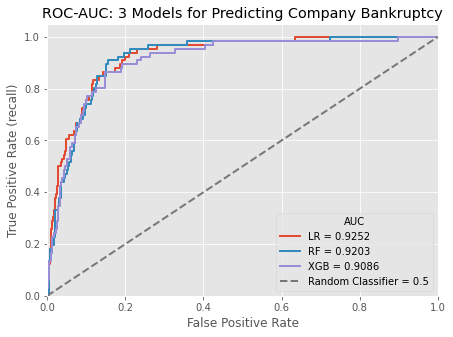

In [32]:
#Plot ROC, with ROC-AUC in the legend

lr_optimized.fit(X_train,y_train)
lr_y_pred = lr_optimized.predict(X_test)
lr_clf_pred_prob = lr_optimized.predict_proba(X_test)
lr_clf_lr_probs = lr_clf_pred_prob[:,1]
lr_clf_lr_fpr, lr_clf_lr_tpr, _ = roc_curve(y_test, lr_clf_lr_probs)
lr_clf_lr_roc_auc = auc(lr_clf_lr_fpr, lr_clf_lr_tpr)

rf_optimized.fit(X_train,y_train)
rf_y_pred = rf_optimized.predict(X_test)
rf_clf_pred_prob = rf_optimized.predict_proba(X_test)
rf_clf_lr_probs = rf_clf_pred_prob[:,1]
rf_clf_lr_fpr, rf_clf_lr_tpr, _ = roc_curve(y_test, rf_clf_lr_probs)
rf_clf_lr_roc_auc = auc(rf_clf_lr_fpr, rf_clf_lr_tpr)

xgb_optimized.fit(X_train,y_train)
xgb_y_pred = xgb_optimized.predict(X_test)
xgb_clf_pred_prob = xgb_optimized.predict_proba(X_test)
xgb_clf_lr_probs = xgb_clf_pred_prob[:,1]
xgb_clf_lr_fpr, xgb_clf_lr_tpr, _ = roc_curve(y_test, xgb_clf_lr_probs)
xgb_clf_lr_roc_auc = auc(xgb_clf_lr_fpr, xgb_clf_lr_tpr)


plt.style.use('ggplot')
plt.figure(figsize=(7,5))

lw = 2

plt.plot(lr_clf_lr_fpr, lr_clf_lr_tpr,
         lw=lw, label='LR = %0.4f' % lr_clf_lr_roc_auc)

plt.plot(rf_clf_lr_fpr, rf_clf_lr_tpr,
         lw=lw, label='RF = %0.4f' % rf_clf_lr_roc_auc)

plt.plot(xgb_clf_lr_fpr, xgb_clf_lr_tpr, 
         lw=lw, label='XGB = %0.4f' % xgb_clf_lr_roc_auc)

plt.plot([0, 1], [0, 1], lw=lw, linestyle='--',
         label='Random Classifier = 0.5')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (recall)')
plt.title('ROC-AUC: 3 Models for Predicting Company Bankruptcy')
plt.legend(title='AUC', loc="lower right")
plt.show()

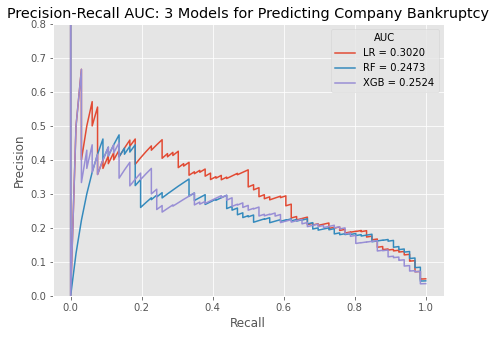

In [35]:
#Precision-Recall curve

lr_clf_pr, lr_clf_re, lr_clf_thr = precision_recall_curve(y_test, lr_clf_lr_probs)
lr_clf_auc = auc(lr_clf_re, lr_clf_pr)

rf_clf_pr, rf_clf_re, rf_clf_thr = precision_recall_curve(y_test, rf_clf_lr_probs)
rf_clf_auc = auc(rf_clf_re, rf_clf_pr)

xgb_clf_pr, xgb_clf_re, xgb_clf_thr = precision_recall_curve(y_test, xgb_clf_lr_probs)
xgb_clf_auc = auc(xgb_clf_re, xgb_clf_pr)

plt.figure(figsize=(7,5))
plt.plot(lr_clf_re, lr_clf_pr, label = 'LR = %0.4f' % lr_clf_auc)
plt.plot(rf_clf_re, rf_clf_pr, label = 'RF = %0.4f' % rf_clf_auc)
plt.plot(xgb_clf_re, xgb_clf_pr, label = 'XGB = %0.4f' % xgb_clf_auc)

plt.title('Precision-Recall AUC: 3 Models for Predicting Company Bankruptcy')
plt.xlim([-0.05, 1.05])
plt.ylim([0.0, 0.8])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.legend(title='AUC', loc='best')
plt.show()

From the ROC curves, we see (surprisingly) that XG Boost performs worse than the other 2 classifiers. Overall, the 3 models plot closely to each other, indicating that their TPR and FPR change similarly. 

From the Precision-Recall curves, it is not too surprising. Remember that precision and recall are defined as the following:
 * precision = TP / (TP + FP)
 * recall = TP / (TP + FN)
Precision and recall both look at True Positives, and do not consider True Negatives in their calculations. So the graph we see is showing us how well our models are able to correctly classify each positive/bankrupt instance with the correct label, but at the expense of generating False Positives (which lowers precision) or False Negatives (which lowers recall).

Given our imbalanced dataset (our postive/bankruptcy class is the minority), and given that our classes do not have a clear separation (as we saw with our PCA and t-SNE plots in "Step 3 - Exploratory Data Analysis"), we can expect Precision to suffer dramatically with each increase in True Positives, since inevitably many neighboring points that are non-bankrupt will get misclassified as bankrupt. 

So in the Precision-Recall curves, we do see that Precision drops dramatically with the slightest increase of recall. 

Interestingly, Logistic Regression has the largest AUC in both the ROC and Precision-Recall curves, indicating that it may be the more robust model for this particular problem.

## 5.7.1 Table of Results<a id='5.7.1'></a>

|Model|Accuracy|F1-Score|Precision|Recall|ROC AUC|P-R AUC|Runtime|
|:-:|--:|--:|--:|--:|--:|--:|--:|
|Logistic Regression|0.8739|0.9103|0.1821|0.8333|0.9252|0.3020|1.9117|
|Random Forest Classifier|0.9355|0.9446|0.2295|0.4242|0.9203|0.2473|6.0768|
|XG Boost Classifier|0.9355|0.9461|0.2574|0.5303|0.9086|0.2524|5.6926|

|Model|TP|FN|TN|FP|
|:-:|--:|--:|--:|--:|
|Logistic Regression|55|11|1733|247|
|Random Forest Classifier|28|38|1886|94|
|XG Boost Classifier|35|31|1879|101|

From the table of results, we see that Logistic Regression had the best Recall, but at the expense of Precision. It correctly classified many of our positive (bankrupt) instances, but at the expense of misclassifying our negatives (non-bankrupt) instances. Random Forest and XG Boost are slightly more balanced, with XG Boost performing better than RF in both Precision and Recall. 

Looking at the F1-score (which is the harmonic mean of Precision and Recall), we see that XG Boost has the highest F1-score of the 3 models. F1-score tends to place more weight on the smaller number, i.e. since Logistic Regression allowed Recall to improve at the expense of Precision, the lower Precision number drags down the total F1-score, giving it the lowest score of the models.

With regards to what model should be implemented in predicting company bankruptcy, that would depend on the domain. From the perspective of an institution deciding whether to insure a small business, or a bank deciding whether to issue a loan, ... the cost of a False Negative (i.e. giving money to a company that will fail) may be greater than the cost of a False Positive (i.e. not giving money to a company that will actually succeed). In that case, we want to minimize FN, and the Logistic Regression Model would be the best choice.

If, however, we are looking from the perspective of an investor(s) deciding which companies to invest their money in, then (depending on the investment strategy) we may not want to be overly conservative and do actually take on some risk in order to not miss out on promising businesses that were misclassified. In this case, we want a more balanced Precision and Recall, and XG Boost would be the best choice.

## 5.8 Summary and Next Steps<a id='5.8'></a>

__Summary:__

In this notebook, we did the following:
* We developed pipelines using the pipeline functions from the imbalanced-learn library (scikit-learn pipeline is incompatible with samplers).
    * A 'preprocessor' pipeline, which preprocesses the data for modeling by: 
        * Scaling the data with np.log1p followed by StandardScaler(),
        * Reduces dimensions with PCA(),
        * Generates cluster labels using K-Means Clustering, and then one-hot encodes those labels and appends it to the existing dataset,
        * Upsamples the training data with SMOTE.
        
    * A Logistic Regression pipeline, which uses the 'preprocessor' steps and ends with the Logistic Regression model.
    * A Random Forest pipeline, which uses the 'preprocessor' steps and ends with the Random Forest Classifier model.
    * A XG Boost pipeline, which uses the 'preprocessor' steps and ends with the XG Boost Classifier model.
* Hyperparameter tuning was done on these pipelines using Randomized Search with 10-fold cross-validation.

The final results showed us that Logistic Regression had the highest Recall and Area-Under-the-Curve for both the ROC and Precision-Recall curves. However, XG Boost was shown to have a more balanced Precision and Recall values, and therefore a higher F1-Score.

Deciding which model (Logistic Regressin or XG Boost) to implement in a real world setting will depend highly on the domain which it would be implemented in. This is discussed more in-depth in the "Table of Results" section above.

__Future Directions:__

Since we conducted hyperparameter tuning on a pipeline rather than an individual model, it can be easy to treat the pipeline as a black box, not truly understanding which features in a company contribute to company bankruptcy. Future actions that can be taken could be to remove the features that failed the t-test or feature with low correlation scores with bankruptcy status in "Step 3 - Exploratory Data Analysis", and then analyze how that affects the model performance. 

We can also use Random Forest or XG Boost on the raw data (without dimensionality reduction), and extract feature importances from the models to see which features played a larger role in classification.

Another avenue to explore is applying these pipelines to American Business data. While this project used a Taiwanese dataset, there are similarities between the Taiwan and US economies--both are capitalist societies, and Taiwan's economy is the 7th largest in Asia and 20th largest in the world, lagging not too far behind from the US despite having only 0.31% of the world population. It is not unfeasible to see how these models transfer to our US business data.